# XAI MODEL BUILD FOR XGB

In [18]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import psutil
import time
import tracemalloc

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [2]:
df_train = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

In [3]:
X_train_unfiltered = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [4]:
X_test_unfiltered = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

## Load Model

In [6]:
# Load the trained model to a specific folder
model_folder = "../../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

# Right Features Retrieval

In [7]:
expected_features = model.feature_names_in_ 

X_train = X_train_unfiltered[expected_features]
X_test = X_test_unfiltered[expected_features]

print("Filtered X_train Shape:", X_train.shape) 
print("Filtered X_test Shape:", X_test.shape)  # Should be (num_samples, 11)

Filtered X_train Shape: (125973, 14)
Filtered X_test Shape: (22544, 14)


## Feature Importance

In [26]:
feature_names = X_train.columns
# feature_names = feature_names[:-1]


🚀 **Computational Overhead Report (Feature Importance)** 🚀
⏳ **Execution Time:** 0.0016 seconds
🔥 **CPU Usage Change:** 5.00%
💾 **Disk I/O Usage:** 2.66 MB
📊 **Peak Memory Usage:** 0.30 MB


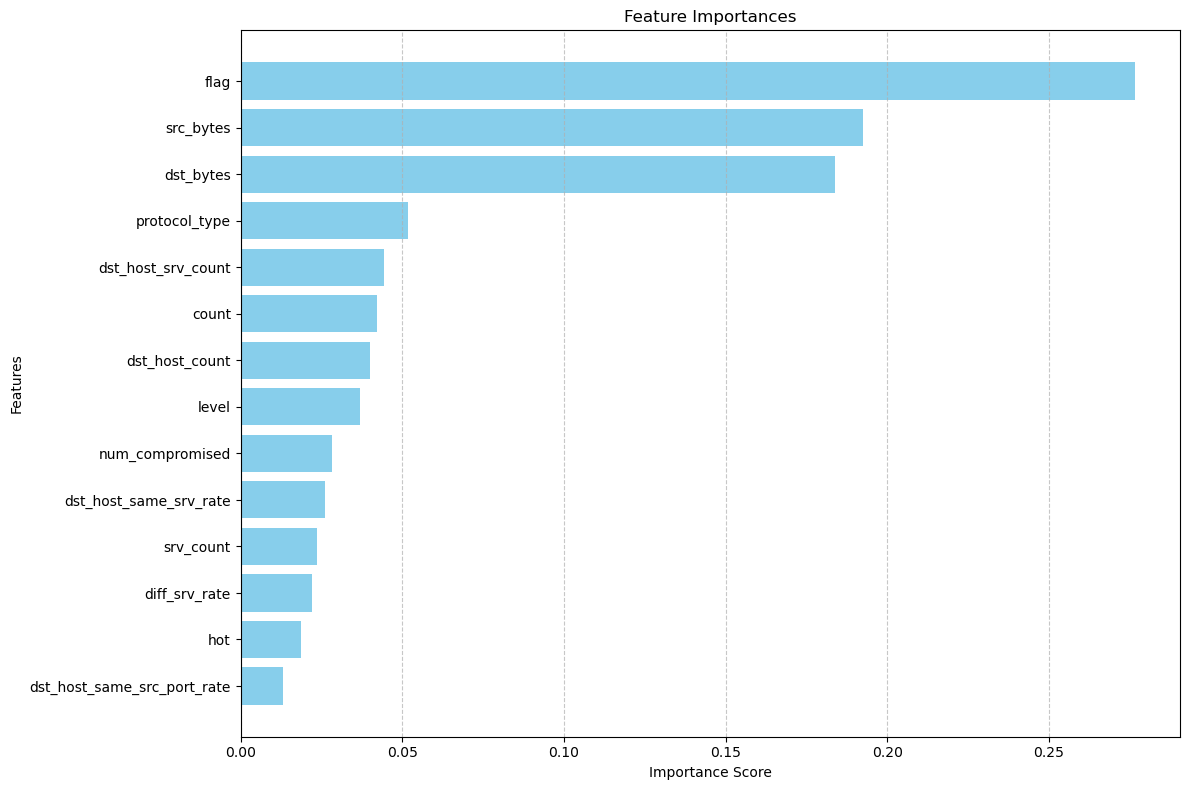

In [27]:
def get_system_stats():
    return {
        "cpu_usage": psutil.cpu_percent(interval=1),
        "memory_info": psutil.virtual_memory().used / (1024 * 1024),  # MB
        "disk_io": psutil.disk_io_counters().write_bytes / (1024 * 1024)  # MB
    }

# Measure initial system stats before feature importance computation
before_stats = get_system_stats()
start_time = time.time()
tracemalloc.start()

importances = model.feature_importances_

# End system tracking
end_time = time.time()
current_memory, peak_memory = tracemalloc.get_traced_memory()
after_stats = get_system_stats()

# Compute overhead
execution_time = end_time - start_time
cpu_usage_change = after_stats["cpu_usage"] - before_stats["cpu_usage"]
memory_used = (peak_memory - current_memory) / (1024 * 1024)  # Convert to MB
disk_io_used = after_stats["disk_io"] - before_stats["disk_io"]

# Print results
print("\n🚀 **Computational Overhead Report (Feature Importance)** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")

fig, ax = plt.subplots(figsize=(12, 8))
feature_names_array = np.array(feature_names)
num_features = min(importances.shape[0], len(feature_names_array))

# Sort indices and ensure we only take the valid range
indices = np.argsort(importances)[::-1][:num_features]  # Fix: Only take the top num_features

if len(feature_names_array) < num_features:
    raise ValueError(f"Mismatch: feature_names has {len(feature_names_array)} elements, expected {num_features}")


ax.barh(range(num_features), importances[indices], color="skyblue")

ax.set_yticks(range(num_features))
ax.set_yticklabels(feature_names_array[indices])

ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

ax.invert_yaxis()

ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

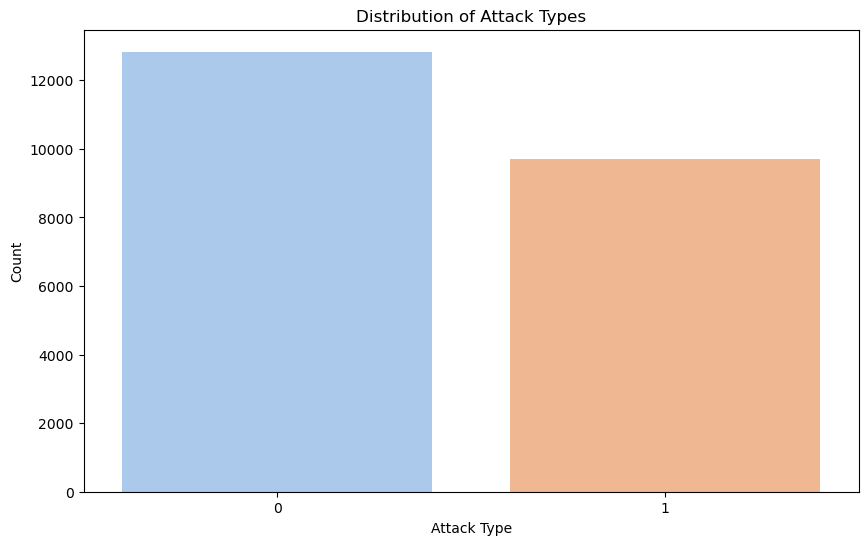

In [28]:
# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, palette="pastel")

# Add labels and title
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.title("Distribution of Attack Types")

# Show the plot
plt.show()

## INTERPRET NSL-KDD MODELS

In [29]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: user 13.5 ms, sys: 1.12 ms, total: 14.6 ms
Wall time: 13.5 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,flag,2,0.276638,1.000000
1,src_bytes,1,0.192442,0.928571
2,dst_bytes,0,0.183769,0.857143
3,protocol_type,4,0.051674,0.785714
4,dst_host_srv_count,8,0.044391,0.714286
5,count,6,0.042266,0.642857
6,dst_host_count,13,0.040033,0.571429
7,level,5,0.036881,0.500000
8,num_compromised,10,0.028167,0.428571
9,dst_host_same_srv_rate,11,0.025989,0.357143


## Morris Sensitivity Analysis

In [30]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

CPU times: user 4.57 s, sys: 89.1 ms, total: 4.66 s
Wall time: 1.83 s
                                    0
level                        0.401453
protocol_type                0.169614
dst_bytes                    0.133634
src_bytes                    0.120149
hot                          0.094704
count                        0.085363
dst_host_same_src_port_rate  0.057671
dst_host_srv_count           0.050694
diff_srv_rate                0.035819
srv_count                    0.029601
dst_host_same_srv_rate       0.023977
flag                         0.016496
dst_host_count               0.014986
num_compromised              0.010672


<!-- http://127.0.0.1:7283/5604042256/ -->

## LOFO IMPORTANCE

/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1742
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of d

  0%|          | 0/14 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1723
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1739
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
3,level,7.658571e-04,0.000268,0.000728,1.109694e-03,3.679417e-04,0.000857
9,dst_bytes,1.282677e-05,0.000052,-0.000009,1.115206e-05,-4.568749e-05,0.000095
5,hot,6.973643e-06,0.000009,0.000007,-5.127385e-07,-7.710968e-07,0.000022
0,num_compromised,3.791226e-06,0.000007,0.000000,0.000000e+00,1.516490e-05,0.000000
1,dst_host_srv_count,2.401597e-07,0.000031,-0.000043,-1.615126e-05,3.444232e-05,0.000026
11,src_bytes,-1.860973e-06,0.000057,0.000015,-8.332000e-06,-8.610581e-05,0.000072
12,dst_host_count,-2.188645e-06,0.000031,-0.000021,2.332960e-05,-4.253884e-05,0.000032
6,flag,-5.337839e-06,0.000066,0.000013,-8.588369e-06,-1.055117e-04,0.000080
8,diff_srv_rate,-1.046448e-05,0.000032,-0.000021,4.486462e-06,-5.629007e-05,0.000031
7,count,-1.855291e-05,0.000083,-0.000034,-8.203816e-06,-1.326287e-04,0.000101


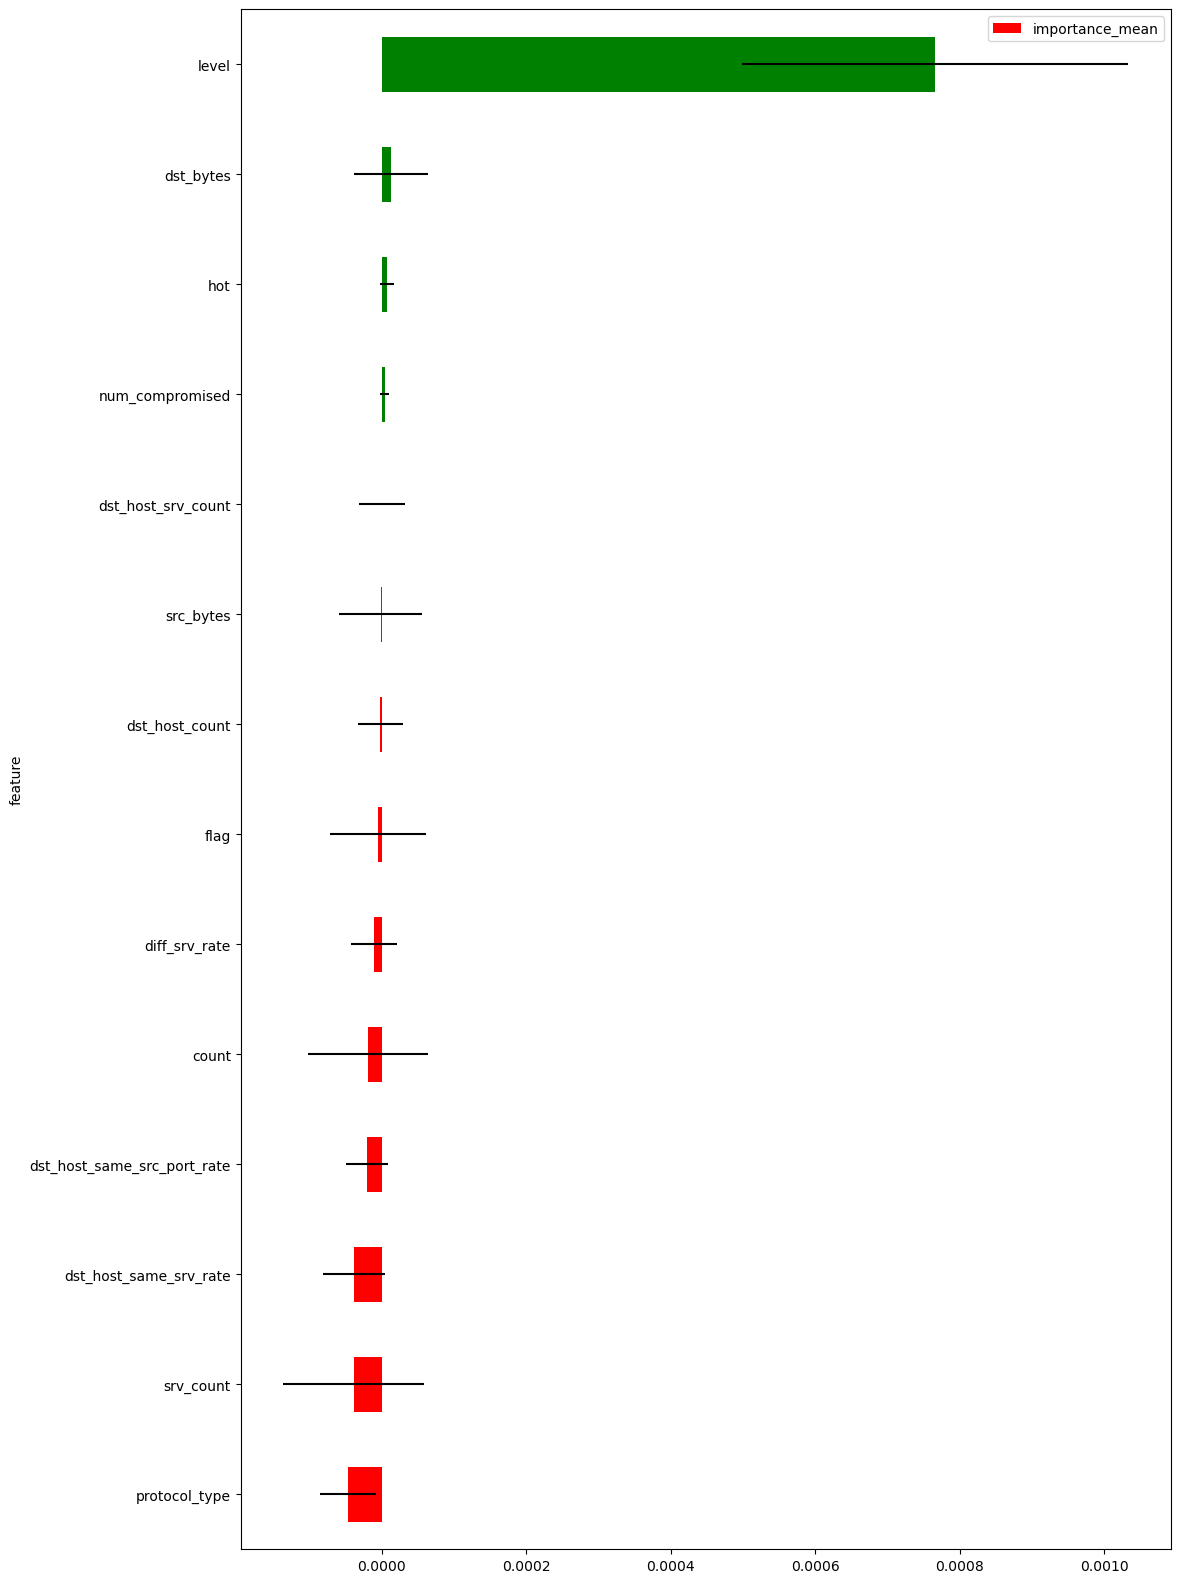

In [31]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    # plot the means and standard deviations of the importances
    plot_importance(importance, figsize=(12, 20))
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="binary_attack", feature_names=feature_names)

importance


## SHAP EXPLAINABILITY

100%|===================| 22542/22544 [00:40<00:00]        

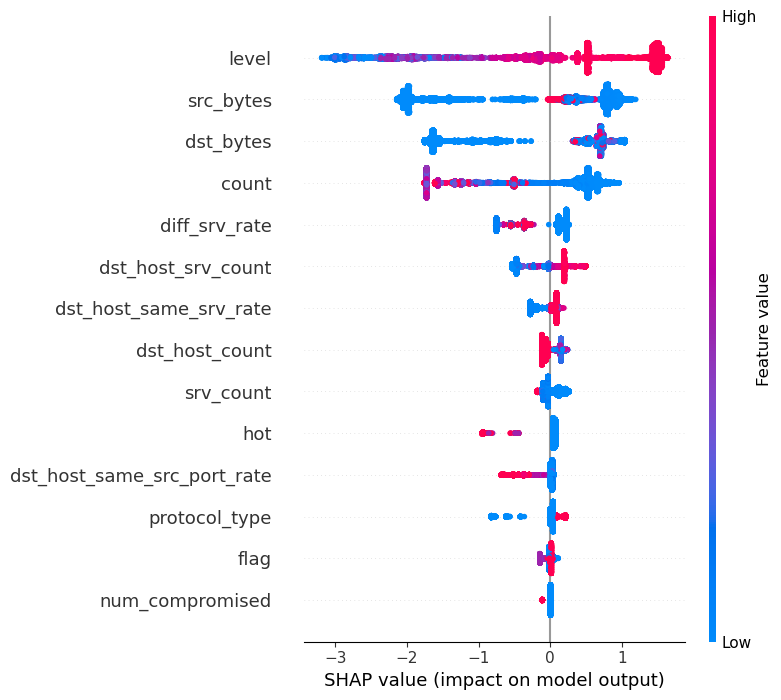

In [32]:
import shap

shap.initjs()

# Ensure X_test has column names matching X_train
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test)

# Get SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot (for individual predictions)
# Extract the base value and SHAP values for a specific prediction
base_value = shap_values.base_values[0]  # Base value for the first prediction
shap_values_for_instance = shap_values.values[0]  # SHAP values for the first instance
features = X_test.iloc[0]  # Features for the first instance

# Create the force plot
shap.force_plot(
    base_value,
    shap_values_for_instance,
    features
)


# EVALUATION METRICS

## SHAP LEQ and GEU

In [33]:
import numpy as np
from scipy.stats import spearmanr

# Functions for Metrics
def calculate_local_explanation_quality(predicted_explanations, actual_model_outputs):
    """
    Calculate the Local Explanation Quality (Fidelity Local).

    Args:
        predicted_explanations (np.ndarray): Predicted explanation outputs (e.g., SHAP predicted values).
        actual_model_outputs (np.ndarray): Actual local model outputs.

    Returns:
        float: Local explanation quality score.
    """
    N = len(predicted_explanations)
    fidelity_local = 1 - (np.sum((predicted_explanations - actual_model_outputs) ** 2) / N)
    return fidelity_local

def calculate_global_explanation_utility(feature_importance_values, domain_importance_values):
    """
    Calculate the Global Explanation Utility using Spearman's Rank Correlation.

    Args:
        feature_importance_values (np.ndarray): Feature importance values (e.g., SHAP feature importance).
        domain_importance_values (np.ndarray): Domain knowledge importance values.

    Returns:
        float: Spearman's Rank Correlation.
    """
    if len(feature_importance_values) != len(domain_importance_values):
        raise ValueError("The number of domain importance scores must match the number of SHAP features.")
    correlation, _ = spearmanr(feature_importance_values, domain_importance_values)
    return correlation

## 1. SHAP Local Explanation Quality (LEQ) (Fidelity)

In [34]:
shap_predicted_values = shap_values.values[:, 0]  # Predicted explanation outputs for the first class

# Actual model outputs for the test set
actual_model_outputs = model.predict_proba(X_test)[:, 0]  # Predicted probabilities for the first class

# SHAP Feature Importance
shap_feature_importance = np.mean(np.abs(shap_values.values), axis=0)  # Average absolute SHAP values

# Domain Knowledge Importance Scores
# Replace with meaningful values for your domain or use uniform values for testing
domain_importance_scores = np.array([
    0.07,  # level
    0.10,  # src_bytes (important for intrusion detection)
    0.08,  # dst_host_srv_count
    0.07,  # dst_bytes
    0.08,  # count
    0.06,  # protocol_type
    0.07,  # dst_host_diff_srv_rate
    0.07,  # dst_host_same_srv_rate
    0.05,  # service
    0.06,  # rerror_rate
    0.04,  # logged_in
    0.07,  # dst_host_srv_serror_rate
    0.07,  # serror_rate
    0.06   # dst_host_rerror_rate
])

# Normalize to sum to 1
domain_importance_scores /= domain_importance_scores.sum()

# Ensure SHAP and domain importance lengths match
if len(shap_feature_importance) != len(domain_importance_scores):
    raise ValueError("The number of domain importance scores must match the number of SHAP features.")

# Calculate the Metrics
local_quality = calculate_local_explanation_quality(shap_predicted_values, actual_model_outputs)

# Outputs
print(f"SHAP Local Explanation Quality (Fidelity Local): {local_quality:.4f}")

SHAP Local Explanation Quality (Fidelity Local): -1.5205


## 2. SHAP Global Explanation Utility

In [35]:
global_utility = calculate_global_explanation_utility(shap_feature_importance, domain_importance_scores)

# Outputs
print(f"SHAP Global Explanation Utility (Spearman's Rank Correlation): {global_utility:.4f}")

SHAP Global Explanation Utility (Spearman's Rank Correlation): 0.0414


# LLM Explainability Of SHAP

In [36]:
import os
import openai

In [37]:
# Prepare SHAP explanation values for the first instance
shap_description_prompt = f"""
Given the following SHAP values for a machine learning model prediction:

Base Value (Average Model Output): {shap_values.base_values[0]}
SHAP Values: {shap_values.values[0]}
Feature Values: {X_test.iloc[0].to_dict()}

Explain the prediction in simple English and provide clear actionable insight to a network analyst.
"""


response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",
    prompt=shap_description_prompt,
    max_tokens=400,
    temperature=0.7  
)

print("Plain English Explanation")
print(response["choices"][0]["text"])


Plain English Explanation

Based on the SHAP values provided, it appears that the most influential features in this prediction are the flag, level, and dst_host_same_src_port_rate. The negative SHAP values for these features indicate that they are associated with a lower predicted output from the model.

The flag feature, which represents the type of network communication being used, has the most negative impact on the prediction. This suggests that certain types of communication may be associated with a lower likelihood of a network attack.

The level feature, which represents the severity level of the attack, also has a negative impact on the prediction. This could mean that attacks with a higher severity level are less likely to occur.

Lastly, the dst_host_same_src_port_rate feature, which represents the rate of connections from the same source port, also has a negative impact on the prediction. This could indicate that a higher rate of connections from the same source port may be 

# Kernal SHAP

  0%|          | 0/10 [00:00<?, ?it/s]

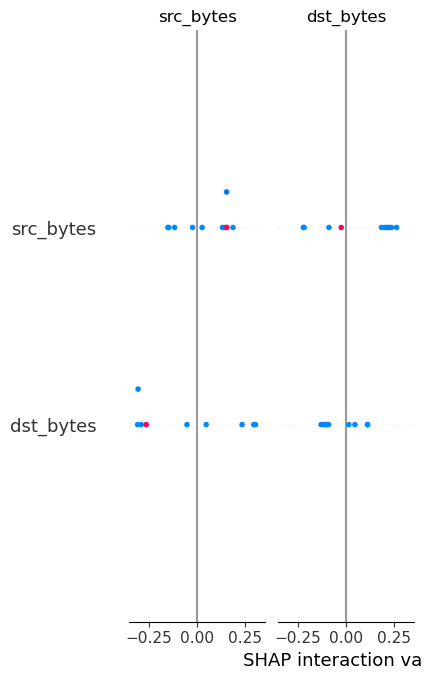

In [38]:
# Define a prediction function for Kernel SHAP
def predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)  # Ensure input has column names
    return model.predict_proba(X_df)

# Initialize Kernel SHAP explainer with a sample of the training data
kernel_explainer = shap.KernelExplainer(predict_proba, shap.sample(X_train, 100))

# Compute SHAP values for the first 10 instances of X_test
kernel_shap_values = kernel_explainer.shap_values(X_test.iloc[:10])  # Limit to 10 instances to save time

# Visualize global feature importance using a summary plot
shap.summary_plot(kernel_shap_values, X_test.iloc[:10])


# Waterfall Plot

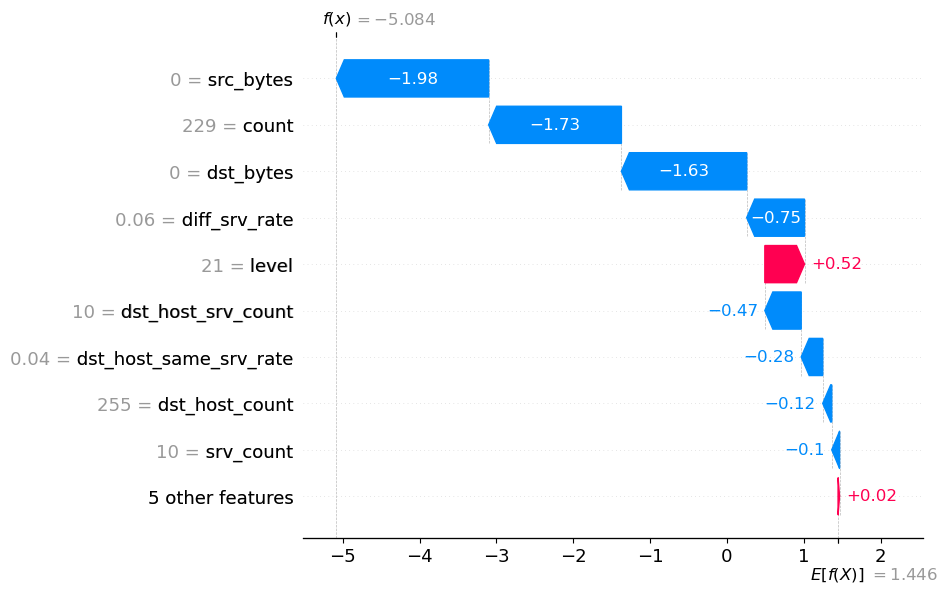

In [39]:
shap.plots.waterfall(shap_values[0])

## LIME EXPLAINABILITY

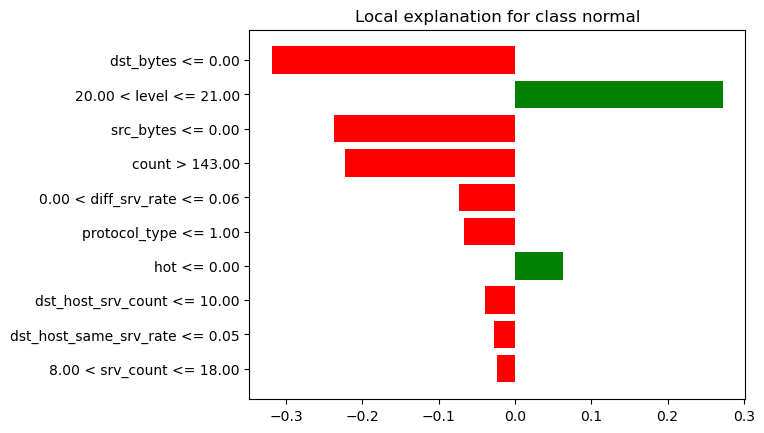

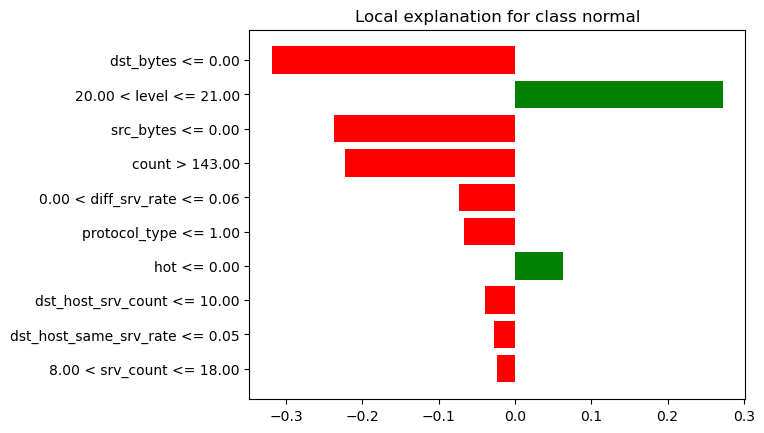

In [40]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),  # Training data as a NumPy array
    feature_names=X_train.columns,   # Feature names
    class_names=['malicious', 'normal'],  # Replace with your model's class labels
    mode='classification'            # Use 'regression' for regression models
)

# Pick a test instance to explain
test_instance = X_test.iloc[0]

# Explain the prediction for the selected test instance
lime_explanation = lime_explainer.explain_instance(
    data_row=test_instance,         # The test instance to explain
    predict_fn=model.predict_proba  # Prediction function (returns probabilities)
)

# Show the explanation in a human-readable format
lime_explanation.show_in_notebook(show_table=True)

# Visualize LIME explanation as a chart
lime_explanation.as_pyplot_figure()


# LIME Explanations

In [41]:
# Extract LIME feature importance
lime_feature_importance = np.zeros(len(X_train.columns))
for feature, weight in lime_explanation.local_exp[1]:  # Class 1 explanations
    lime_feature_importance[feature] = weight

# Normalize LIME feature importance for global utility
lime_feature_importance_normalized = np.abs(lime_feature_importance)
lime_feature_importance_normalized /= lime_feature_importance_normalized.sum()

# Get actual model predictions
actual_model_outputs = model.predict_proba(X_test)[:, 1]  # Use probabilities for class 1
lime_predicted_explanations = model.predict_proba(X_test)[:, 1]  # Use the same model outputs for simplicity

# Domain Importance Scores (same as before)
domain_importance_scores = np.array([
    0.07,  # level
    0.10,  # src_bytes (important for intrusion detection)
    0.08,  # dst_host_srv_count
    0.07,  # dst_bytes
    0.08,  # count
    0.06,  # protocol_type
    0.07,  # dst_host_diff_srv_rate
    0.07,  # dst_host_same_srv_rate
    0.05,  # service
    0.06,  # rerror_rate
    0.04,  # logged_in
    0.07,  # dst_host_srv_serror_rate
    0.07,  # serror_rate
    0.06   # dst_host_rerror_rate
])

# Ensure Domain Importance Scores are Normalized
domain_importance_scores /= domain_importance_scores.sum()

# 1. LIME Local Explanation Quality (Fidelity)

In [42]:
# Calculate Metrics
local_quality_lime = calculate_local_explanation_quality(
    lime_predicted_explanations, actual_model_outputs
)

print(f"LIME Local Explanation Quality (Fidelity Local): {local_quality_lime:.4f}")

LIME Local Explanation Quality (Fidelity Local): 1.0000


## 2. LIME Global Explanation Utility

In [43]:
global_utility_lime = calculate_global_explanation_utility(
    lime_feature_importance_normalized, domain_importance_scores
)

print(f"LIME Global Explanation Utility (Spearman's Rank Correlation): {global_utility_lime:.4f}")

LIME Global Explanation Utility (Spearman's Rank Correlation): 0.2816


# LLM Explainability Of LIME

In [44]:
lime_values = lime_explanation.as_list()
lime_description_prompt = f"""
Given the following LIME values for a machine learning model prediction:

Base Prediction (Average Model Output): {lime_explanation.intercept}
LIME Values (Feature Contributions):
{', '.join([f"{feature}: {contribution:.4f}" for feature, contribution in lime_values])}

Explain the prediction in simple English and provide clear actionable insight for a network analyst.
"""

# Generate explanation using the OpenAI API
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",  
    prompt=lime_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

# Print the explanation
print("Plain English Explanation \n")
print(response["choices"][0]["text"].strip())


Plain English Explanation 

The LIME values represent the contribution of each feature to the overall prediction of the machine learning model. In this case, the model output is an average of 0.7669, which means that the model predicts a high likelihood of the network traffic being malicious.

The feature "dst_bytes <= 0.00" has the highest negative contribution, meaning that if this feature is present in the network traffic, it decreases the likelihood of the traffic being malicious. This could indicate that low destination bytes are a common characteristic of benign traffic, and the model is using this feature to distinguish between benign and malicious traffic.

The feature "20.00 < level <= 21.00" has the highest positive contribution, suggesting that if this feature is present, it increases the likelihood of the traffic being malicious. This feature could represent a specific level of a network protocol that is commonly associated with malicious activity.

Other features with nega